<a href="https://colab.research.google.com/github/Aravinda89/multi_label_classification/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai==2.0.19 fastcore==1.3.2

     |████████████████████████████████| 188 kB 5.0 MB/s 
     |████████████████████████████████| 46 kB 3.4 MB/s 
     |████████████████████████████████| 5.9 MB 26.8 MB/s 
     |████████████▊                   | 298.7 MB 1.4 MB/s eta 0:05:23

In [2]:
from fastai.vision.all import *
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F


In [3]:
path = untar_data(URLs.CAMVID)

In [11]:
ls /root/.fastai/data/camvid/

codes.txt  images/  labels/  valid.txt


In [14]:
code = (path/'codes.txt').read_text()
code

'Animal\nArchway\nBicyclist\nBridge\nBuilding\nCar\nCartLuggagePram\nChild\nColumn_Pole\nFence\nLaneMkgsDriv\nLaneMkgsNonDriv\nMisc_Text\nMotorcycleScooter\nOtherMoving\nParkingBlock\nPedestrian\nRoad\nRoadShoulder\nSidewalk\nSignSymbol\nSky\nSUVPickupTruck\nTrafficCone\nTrafficLight\nTrain\nTree\nTruck_Bus\nTunnel\nVegetationMisc\nVoid\nWall\n'

In [15]:
valid = (path/'valid.txt').read_text()
valid

'0016E5_07959.png\n0016E5_07961.png\n0016E5_07963.png\n0016E5_07965.png\n0016E5_07967.png\n0016E5_07969.png\n0016E5_07971.png\n0016E5_07973.png\n0016E5_07975.png\n0016E5_07977.png\n0016E5_07979.png\n0016E5_07981.png\n0016E5_07983.png\n0016E5_07985.png\n0016E5_07987.png\n0016E5_07989.png\n0016E5_07991.png\n0016E5_07993.png\n0016E5_07995.png\n0016E5_07997.png\n0016E5_07999.png\n0016E5_08001.png\n0016E5_08003.png\n0016E5_08005.png\n0016E5_08007.png\n0016E5_08009.png\n0016E5_08011.png\n0016E5_08013.png\n0016E5_08015.png\n0016E5_08017.png\n0016E5_08019.png\n0016E5_08021.png\n0016E5_08023.png\n0016E5_08025.png\n0016E5_08027.png\n0016E5_08029.png\n0016E5_08031.png\n0016E5_08033.png\n0016E5_08035.png\n0016E5_08037.png\n0016E5_08039.png\n0016E5_08041.png\n0016E5_08043.png\n0016E5_08045.png\n0016E5_08047.png\n0016E5_08049.png\n0016E5_08051.png\n0016E5_08053.png\n0016E5_08055.png\n0016E5_08057.png\n0016E5_08059.png\n0016E5_08061.png\n0016E5_08063.png\n0016E5_08065.png\n0016E5_08067.png\n0016E5_08

In [16]:
valid_fnames = (path/'valid.txt').read_text().split('\n')

In [17]:
valid_fnames[:5]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

In [18]:
path_im = path/'images'
path_lbl = path/'labels'

In [19]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

In [34]:
len(fnames)

701

In [20]:
fnames[:3]

(#3) [Path('/root/.fastai/data/camvid/images/0016E5_04680.png'),Path('/root/.fastai/data/camvid/images/Seq05VD_f01140.png'),Path('/root/.fastai/data/camvid/images/Seq05VD_f00030.png')]

In [21]:
lbl_names[:3]

(#3) [Path('/root/.fastai/data/camvid/labels/0001TP_010050_P.png'),Path('/root/.fastai/data/camvid/labels/0016E5_05790_P.png'),Path('/root/.fastai/data/camvid/labels/0016E5_06540_P.png')]

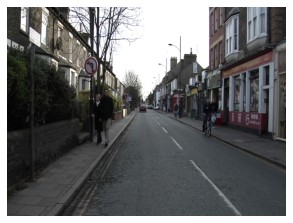

In [29]:
img_fn = fnames[1]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

In [26]:
# ls /root/.fastai/data/camvid/labels
# 0006R0_f02490_P.png  0016E5_07860_P.png  Seq05VD_f03420_P.png

In [30]:
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'

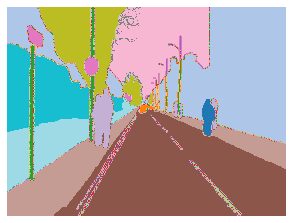

In [31]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

In [32]:
tensor(msk)

tensor([[ 4,  4,  4,  ...,  4,  4,  4],
        [ 4,  4,  4,  ...,  4,  4,  4],
        [ 4,  4,  4,  ...,  4,  4,  4],
        ...,
        [19, 19, 19,  ..., 17, 17, 17],
        [19, 19, 19,  ..., 17, 17, 17],
        [19, 19, 19,  ..., 17, 17, 17]], dtype=torch.uint8)

In [33]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [36]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner